# Imperfect Model Experiments: Arctic Sea ice (sic/sit) 850--1850

## Figure 2 and S2
  
Katie Brennan  
August 2020 
  
Experiments drawing observations from the MPI last millennium run at the proxy locations and observations errors drawn from the Pages2kv2 dataset. They were then assimilated into a 200 member prior ensemble drawn from the CCSM4 last millennium run to test this techniqe in a perfect model environment from 850--1850. 
  
Here I want to investigate if there is a difference in performance as the number of observations increases with time. I want to look at the evolution of skill metrics like R$^2$ and CE values in time. Is there a section of time in 850--1850 that is more trustworthy that we should rely on more than others? 
  
Also I updated the code to include Sea ice thickness which I'd like to look at for my own curiosity. It may or may not end up in the paper. 

#### Conclusions: 



In [4]:
import sys,os,copy

In [5]:
import sys
import numpy as np
import pickle

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec

In [6]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/kalman2/mkb22/LMR_lite/')
import LMR_utils 

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_utils_kb/')
import Sice_utils as siutils 
import stats_utils as kbstats

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [7]:
import importlib
# #importlib.reload(LMRlite)
# #importlib.reload(LMR_config)
# importlib.reload(LMRlite)
importlib.reload(ce_utils)

<module 'commonera_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/commonera_utils.py'>

In [8]:
plt.rcParams['figure.dpi']=200

In [9]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [10]:
def load_mpi_lm_regridded():
    mpi_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/MPI/'
    mpi_file = 'mpi_sic_sit_tas_20CRv2_850_1850_full.npz'

    mpi_lm = np.load(mpi_dir+mpi_file)

    mpi_truth_sic = mpi_lm['sic_mpi']
    mpi_truth_sit = mpi_lm['sit_mpi']
    mpi_truth_tas = mpi_lm['tas_mpi']
    mpi_truth_lat = mpi_lm['lat_mpi']
    mpi_truth_lon = mpi_lm['lon_mpi']
    
    return mpi_truth_tas, mpi_truth_sic, mpi_truth_sit, mpi_truth_lat, mpi_truth_lon

In [11]:
def calc_ccsm4_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, ccsm4_truth_time,anom_start, anom_end):
    # NH surface area in M km^2 from concentration in percentage
    nharea = 2*np.pi*(6380**2)/1e8

    sie_lalo_ccsm4 = siutils.calc_sea_ice_extent(ccsm4_truth_sic,15.0)

    _,nh_sic_truth,_ = LMR_utils.global_hemispheric_means(ccsm4_truth_sic,ccsm4_truth_lat[:,0])
    _,nh_sie_truth,_ = LMR_utils.global_hemispheric_means(sie_lalo_ccsm4,ccsm4_truth_lat[:,0])
    sia_ccsm4_truth = nh_sic_truth*nharea
    sie_ccsm4_truth = nh_sie_truth*nharea
    
    anom_int = np.where((ccsm4_truth_time>=anom_start)&(ccsm4_truth_time<anom_end+1))

    sia_ccsm4_truth_anom = sia_ccsm4_truth - np.nanmean(sia_ccsm4_truth[anom_int])
    sie_ccsm4_truth_anom = sie_ccsm4_truth - np.nanmean(sie_ccsm4_truth[anom_int])
    
    return sia_ccsm4_truth, sie_ccsm4_truth, sia_ccsm4_truth_anom, sie_ccsm4_truth_anom

In [12]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    
    ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
#    plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)
    
    return cs

In [13]:
def plot_pseudo_tm_validation(ax, time, truth, recon_time, recon, recon_2_5, recon_97_5, 
                              corr_tot, ce_tot, corr_sie_mod, ce_sie_mod, min, max):
    ax.axhline(0,linestyle='--',color='grey')

    ax.plot(time, truth, label='Target (MPI LM)',color='k',linewidth=2)
    ax.plot(recon_time, recon, label = 'Reconstruction (pseudo proxy)',color='royalblue',linewidth=1.0)

    ax.fill_between(recon_time,recon_2_5,recon_97_5,color='royalblue',alpha=0.25)

    ax.set_ylabel('Arctic sea-ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
    ax.set_xlabel('Year (CE)',fontsize=12)
    #plt.title('Total Arctic Sea Ice Extent', fontsize=14)
    
    ax.set_xticks(np.arange(850,1851,100))

    ax.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
    ax.set_ylim(-3,4,1)
    
    ce_corr_plt_ccsm4 = (('(Target, Reconstruction):     R$^2$ = ' + 
                          '{:,.2f}'.format(corr_tot**2))+
                         ', CE = '+'{:,.2f}'.format(ce_tot))
    ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R$^2$ = ' + 
                          '{:,.2f}'.format(corr_sie_mod**2))+
                         ', CE = '+'{:,.2f}'.format(ce_sie_mod))

#     plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
#     plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='royalblue')
#    ax.text(850, -2.0, ce_corr_plt_mod , fontsize=13,color='k')
    ax.text(850, -2.4, ce_corr_plt_ccsm4 , fontsize=13,color='k')

    ax.set_xlim(840,1860)
    ax.set_ylim(min,max)

In [14]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

### Load Last Millennium 'truth' simulation: 

In [15]:
recon_start = 850
recon_end = 1849

In [16]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

[sia_nh_ccsm4_truth, sie_nh_ccsm4_truth, 
 sia_nh_ccsm4_truth_anom, sie_nh_ccsm4_truth_anom,
 sia_sh_ccsm4_truth, sie_sh_ccsm4_truth, 
 sia_sh_ccsm4_truth_anom, 
 sie_sh_ccsm4_truth_anom] = ce_utils.calc_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, 
                                                    ccsm4_truth_time, recon_start, recon_end)

In [17]:
[mpi_truth_tas, mpi_truth_sic, 
 mpi_truth_sit,
 mpi_truth_lat, mpi_truth_lon] = load_mpi_lm_regridded()

mpi_time = np.arange(850,1850,1)

[sia_nh_mpi, sie_nh_mpi, 
 sia_nh_mpi_anom, sie_nh_mpi_anom,
 sia_sh_mpi, sie_sh_mpi, 
 sia_sh_mpi_anom, sie_sh_mpi_anom] = ce_utils.calc_lm_tot_si(mpi_truth_sic,mpi_truth_lat, 
                                                             mpi_time, recon_start, recon_end)

In [18]:
it_ccsm4 = np.where(ccsm4_truth_time>=recon_start)
it_mpi = np.where(mpi_time>=recon_start)
 
sia_nh_ccsm4_truth_anom = sia_nh_ccsm4_truth_anom[it_ccsm4]
sie_nh_ccsm4_truth_anom = sie_nh_ccsm4_truth_anom[it_ccsm4]
sia_sh_ccsm4_truth_anom = sia_sh_ccsm4_truth_anom[it_ccsm4]
sie_sh_ccsm4_truth_anom = sie_sh_ccsm4_truth_anom[it_ccsm4]

sia_nh_mpi_anom = sia_nh_mpi_anom[it_mpi]
sie_nh_mpi_anom = sie_nh_mpi_anom[it_mpi]
sia_sh_mpi_anom = sia_sh_mpi_anom[it_mpi]
sie_sh_mpi_anom = sie_sh_mpi_anom[it_mpi]

In [19]:
[ce_sie_mod,
 corr_sie_mod,_,_] = rrutils.find_ce_corr(sie_nh_ccsm4_truth_anom, 
                                          sie_nh_mpi_anom,
                                          mpi_time[it_mpi],
                                          ccsm4_truth_time[it_ccsm4],
                                          recon_start, recon_end)

corr_sie_mod**2,ce_sie_mod

(0.035515127251206355, -0.5414335155330279)

In [20]:
np.var(sie_nh_ccsm4_truth_anom), np.var(sie_nh_mpi_anom)

(0.32535502131094285, 0.3623684779049746)

## Figure S2: 

In [21]:
mpi_sic_spatialmn = np.nanmean(mpi_truth_sic,axis=0)
ccsm4_sic_spatialmn = np.nanmean(ccsm4_truth_sic,axis=0)

lm_diff = ccsm4_sic_spatialmn - mpi_sic_spatialmn

lm_diff_plot = np.where(np.abs(lm_diff)<0.05,np.nan,lm_diff)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


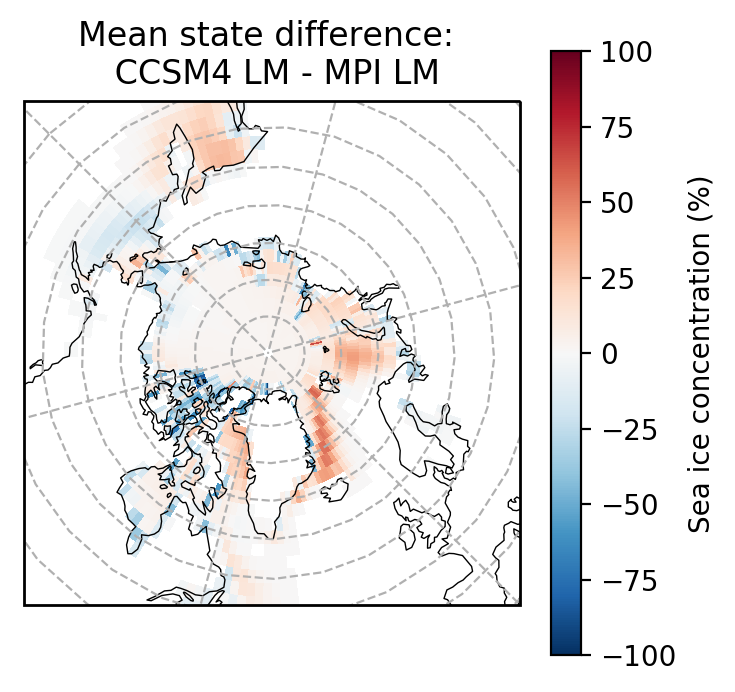

In [22]:
fig,ax = plt.subplots(1,1, figsize=(4, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax,lm_diff_plot,
                     ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Mean state difference: \n CCSM4 LM - MPI LM',100)

plt.colorbar(cs,ax=ax,label='Sea ice concentration (%)')

#fig.suptitle('Last Millennium simulations mean state difference', fontsize=14,x=0.43)
#plt.tight_layout(rect=(0,0.05,0.92,0.94))

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'CCSM4_minus_MPI_LM_mean_state_diff.png'
#plt.savefig(savedir+savename)

### Load psedo experiments, R = Pages2kv2 values: 

In [23]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo_sis/'
output_file_ccsm4 = 'sic_sit_ccsm4_anrecon_850_1850_pseudo_sis_mpi_true_inf2_6_loc15000_Rpages2kv2_iter0.pkl'
niter = 10

[sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, 
 nobs_allit, obs_loc_allit, sia_Nens_allit, sie_Nens_allit, 
 sia_Sens_allit, sie_Sens_allit, Xb_inflate_allit, prox_lat, prox_lon, 
 recon_years, tas_truth_allit, sit_lalo_allit, sit_Nens_allit, 
 sit_Sens_allit] = ce_utils.load_sit_pseudo_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

## Northern Hemisphere skill: 

In [24]:
sie_Nens_allit_2d = np.reshape(sie_Nens_allit,
                               (sie_Nens_allit.shape[0],
                                sie_Nens_allit.shape[1]*sie_Nens_allit.shape[2]))
sie_ens_anom_allit = sie_Nens_allit_2d - np.nanmean(sie_Nens_allit_2d,axis=0)
sie_ccsm4_recon_anom = np.mean(sie_ens_anom_allit,axis=1)

sie_recon_97_5_anom = np.percentile(sie_ens_anom_allit,97.5,axis=1)
sie_recon_2_5_anom = np.percentile(sie_ens_anom_allit,2.5,axis=1)

In [25]:
np.nanmean(sie_Nens_allit_2d,axis=0).shape, sie_Nens_allit_2d.shape

((2000,), (1000, 2000))

In [26]:
yr = 850
[ce_tot,corr_tot,_,_] = rrutils.find_ce_corr(sie_ccsm4_recon_anom,
                                             sie_nh_mpi_anom, 
                                             mpi_time[it_mpi],
                                             np.array(recon_years),
                                             yr,1849)

print('CE (850-1850) = '+str(ce_tot))
print('R^2 (850-1850) = '+str(corr_tot**2))

CE (850-1850) = 0.4333869844389574
R^2 (850-1850) = 0.4344480655920037


In [27]:
seg_length =500
ce_sie_pseudo = []
corr_sie_pseudo = []

for yr in range(recon_years[0],recon_years[-1]-seg_length+1): 
#    print(str(yr))
    [ce_seg,
     corr_seg,_,_] = rrutils.find_ce_corr(sie_ccsm4_recon_anom,
                                          sie_nh_mpi_anom,
                                          mpi_time[it_mpi],
                                          np.array(recon_years),
                                          yr,yr+seg_length)

    ce_sie_pseudo = np.append(ce_sie_pseudo,ce_seg)
    corr_sie_pseudo = np.append(corr_sie_pseudo,corr_seg)

#### Load proxy locations for plotting: 

In [28]:
proxinfo_loc = ('/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/'+
            'experiments/pseudo/pages2kv2_all_proxy_info.pkl')

prox_loc_info = pickle.load(open(proxinfo_loc,'rb'))

In [29]:
proxy_types = ['Tree Rings_WidthPages2', 'Tree Rings_WoodDensity', 
               'Ice Cores_d18O', 'Ice Cores_dD', 
               'Ice Cores_MeltFeature', 'Lake Cores_Varve',
               'Lake Cores_Misc']

### Spatial validation: SIC

In [30]:
sic_shape = sic_lalo_allit.shape
sic_shape_true = mpi_truth_sic.shape

sic_lalo_ensmn = np.nanmean(sic_lalo_allit,axis=3)
sic_truth_lalo = np.squeeze(mpi_truth_sic[it_mpi,:,:])
sic_2_5_lalo = np.percentile(sic_lalo_allit,2.5,axis=3)
sic_97_5_lalo = np.percentile(sic_lalo_allit,97.5,axis=3)

sic_prior_ensmn = np.reshape(np.nanmean(Xb_inflate_allit[91*180:91*180*2],axis=2).T,(200,91,180))

sic_recon_2d = np.reshape(sic_lalo_ensmn,(sic_shape[0],sic_shape[1]*sic_shape[2]))
sic_truth_2d = np.reshape(mpi_truth_sic,(sic_shape_true[0],sic_shape_true[1]*sic_shape_true[2]))
sic_truth_2d = np.squeeze(sic_truth_2d[it_mpi,:])

In [31]:
sic_recon_2d_anom = sic_recon_2d - np.nanmean(sic_recon_2d,axis=0)
sic_truth_2d_anom = sic_truth_2d - np.nanmean(sic_truth_2d,axis=0)

In [32]:
r_sic_anom = np.zeros(sic_truth_2d.shape[1])
r2_sic_anom = np.zeros(sic_truth_2d.shape[1])
ce_sic_anom = np.zeros(sic_truth_2d.shape[1])

for lalo in range(sic_truth_2d.shape[1]):
    [r_sic_anom[lalo],
     r2_sic_anom[lalo],_] = kbstats.corr_timeseries(sic_truth_2d_anom[:,lalo],
                                                    sic_recon_2d_anom[:,lalo])
    ce_sic_anom[lalo]= kbstats.coefficient_efficiency(sic_truth_2d_anom[:,lalo],
                                                 sic_recon_2d_anom[:,lalo])
    
r_sic_anom = np.reshape(r_sic_anom,(sic_shape_true[1],sic_shape_true[2]))
ce_sic_anom = np.reshape(ce_sic_anom,(sic_shape_true[1],sic_shape_true[2]))

/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_corr = covariance(X,Y)/(X_stdev*Y_stdev)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:65: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_reg = covariance(X,Y)/(X_stdev**2)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


## Make netcdf file: 

In [34]:
sie_ens_anom_allit_3d = np.reshape(sie_ens_anom_allit,(1000,200,10))

In [35]:
from datetime import datetime
import xarray as xr

datavars = {'si_extent_anomalies':(['time','nens','nit'],
                                         sie_ens_anom_allit_3d,
                                         {'units':'10^6 km^2',
                                          'long_name':'reconstructed total Arctic sea ice extent anomalies',
                                          'anomalies_period':'anomalies relative to full time period (850-1850)'}),
            'si_extent_ensemble_mean_anomalies':(['time'],
                                                 sie_ccsm4_recon_anom,
                                                 {'units':'10^6 km^2',
                                                  'long_name':'reconstructed total Arctic sea ice extent anomalies',
                                                  'anomalies_period':'anomalies relative to full time period (850-1850)'}),
            'si_extent_97_5_percentiles':(['time'],
                                                sie_recon_97_5_anom,
                                                {'units':'10^6 km^2',
                                                'long_name':'97.5th percentile across all 2000 ensemble members of reconstructed total Arctic sea ice extent anomalies'}),
            'si_extent_2_5_percentiles':(['time'],
                                                sie_recon_2_5_anom,
                                                {'units':'10^6 km^2',
                                                'long_name':'2.5th percentile across all 2000 ensemble members of reconstructed total Arctic sea ice extent anomalies'}),
            'sic_lalo_ensemble_mean':(['time','lat','lon'],
                                       sic_lalo_ensmn,
                                       {'units':'percent(%)','long_name':'Sea ice area'})}

coords = {'time':(['time'],np.array(recon_years),{'units':'year (CE)'}),
          'lat':(['lat'],ccsm4_truth_lat[:,0],{'units':'degrees north'}),
          'lot':(['lot'],ccsm4_truth_lon[0,:],{'units':'degrees east'}),
          'nens':(['nens'],np.arange(0,200,1),{'long_name':'ensemble member'}),
          'nit':(['nit'],np.arange(0,10,1),{'long_name':'Monte Carlo iteration'})}

attrs = {'creation_date':'2021-11-16', 
         'author':'M. Kathleen Brennan', 
         'email':'mkb22@uw.edu',
         'experiment': ('Results from imperfect model pseudo proxy experiments where '+
                        'pseudo observations were drawn from MPI Last Millennium simulations and '+
                        'prior ensembles were both drawn from CCSM4 Last Millennium simulations.')}

ds = xr.Dataset(data_vars=datavars,
               coords=coords,
               attrs=attrs)

savedir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
savename = 'Brennan_etal_2021_imperfect_pseudo_experiment.nc'

ds.to_netcdf(savedir+savename)

# Figure 2: 

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


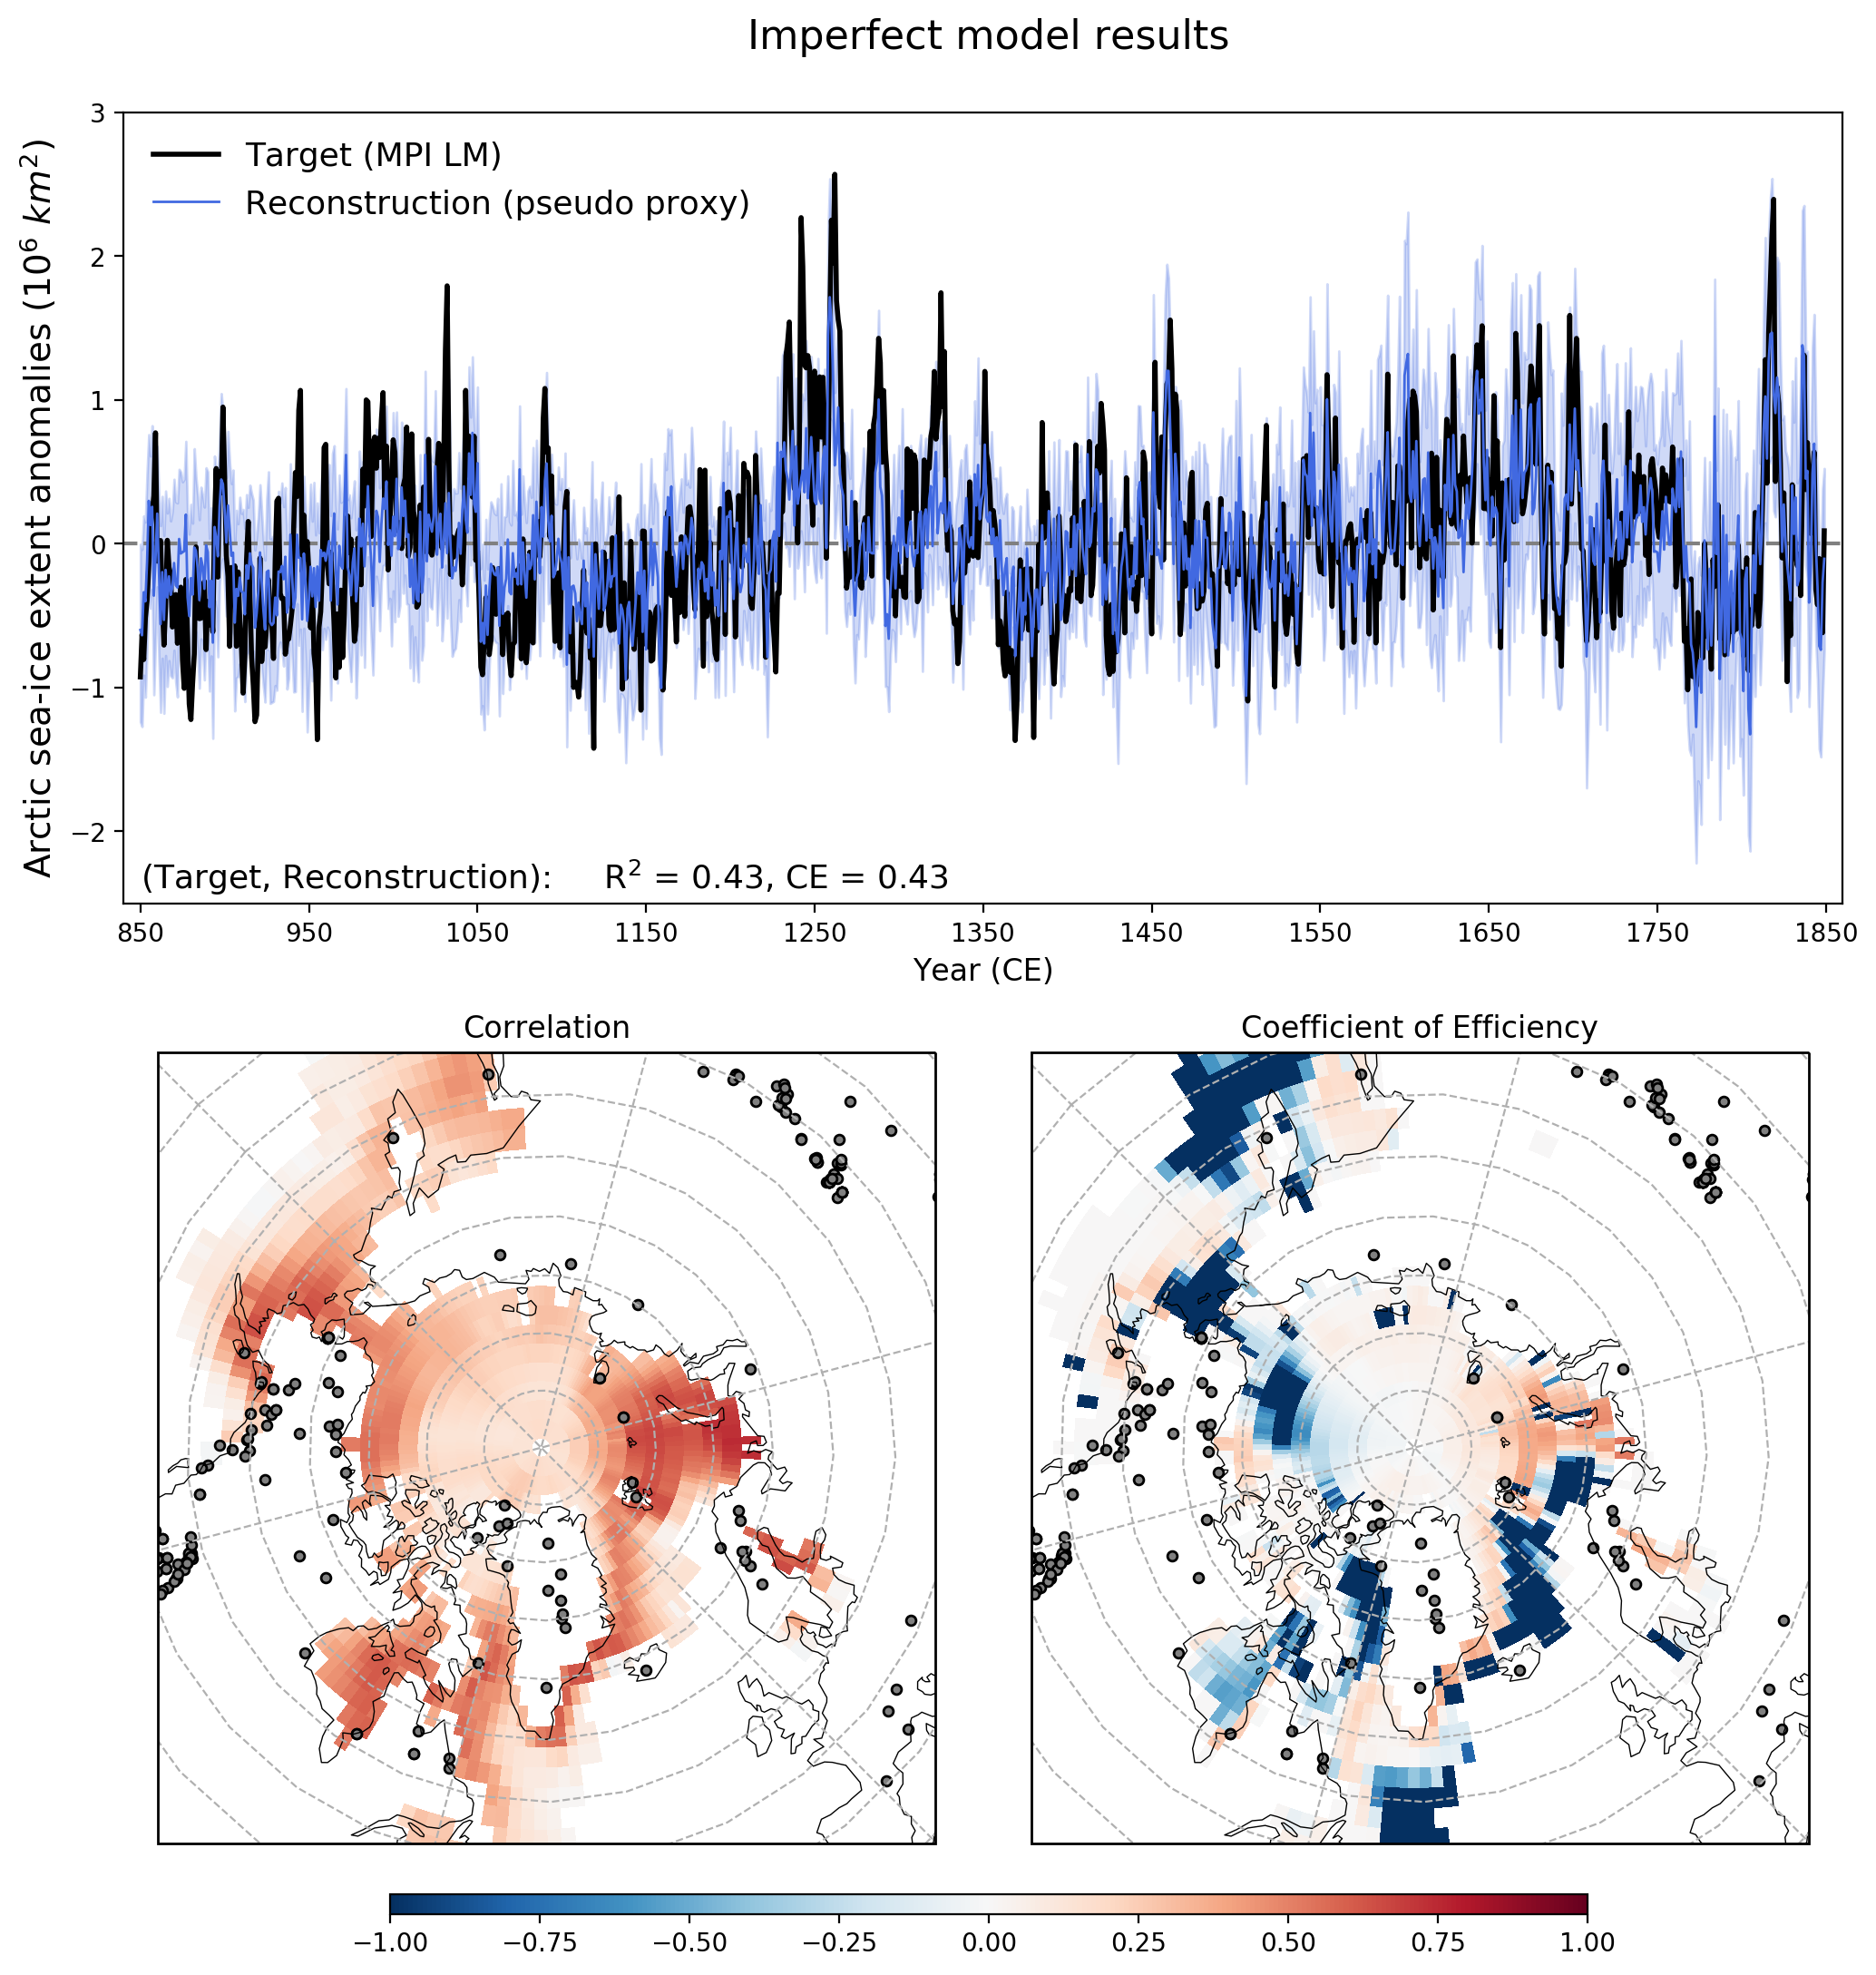

In [30]:
fig= plt.figure(figsize=(11, 11))

gs = gridspec.GridSpec(2,2, figure=fig)

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[-1, 0], projection = ccrs.Stereographic(central_latitude=90,
                                                                 central_longitude=-45,
                                                                 true_scale_latitude=0.1))
ax2 = fig.add_subplot(gs[-1, -1], projection = ccrs.Stereographic(central_latitude=90,
                                                                 central_longitude=-45,
                                                                 true_scale_latitude=0.1))

plot_pseudo_tm_validation(ax0, mpi_time[it_mpi],sie_nh_mpi_anom, recon_years,sie_ccsm4_recon_anom, 
                          sie_recon_2_5_anom,sie_recon_97_5_anom,corr_tot, ce_tot, 
                          corr_sie_mod, ce_sie_mod, -2.5,3)

cs = sub_arctic_plot(fig,ax1,r_sic_anom,mpi_truth_lat[:,0],
                         mpi_truth_lon[0,:],'Correlation',1)
cs = sub_arctic_plot(fig,ax2,ce_sic_anom,mpi_truth_lat[:,0],
                         mpi_truth_lon[0,:],'Coefficient of Efficiency',1)

for ptype in proxy_types: 
    ax1.scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    ax2.scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    
handle_list = []
label_list = []
handles, labels = ax0.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
        
# plt.colorbar(cs,ax=ax2)
position=fig.add_axes([0.2,0.03,0.6,0.01])
cb = plt.colorbar(cs, cax=position, orientation='horizontal')

fig.suptitle('Imperfect model results',fontsize=16)

plt.tight_layout(rect=(0,0.05,0.95,0.96))
#plt.scatter(100, 10, color='m')

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_sis_arctic_sic_anom_space_temp_performance_recon_850_1850_truth_r_CE.png'
plt.savefig(savedir+savename)